In [0]:
pip install graph_nets

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import time

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Helper functions  { form-width: "30%" }

# pylint: disable=redefined-outer-name

def create_graph_dicts_tf(num_examples, num_elements_min_max):
  """Generate graphs for training.

  Args:
    num_examples: total number of graphs to generate
    num_elements_min_max: a 2-tuple with the minimum and maximum number of
      values allowable in a graph. The number of values for a graph is
      uniformly sampled withing this range. The upper bound is exclusive, and
      should be at least 2 more than the lower bound.

  Returns:
    inputs: contains the generated random numbers as node values.
    sort_indices: contains the sorting indices as nodes. Concretely
      inputs.nodes[sort_indices.nodes] will be a sorted array.
    ranks: the rank of each value in inputs normalized to the range [0, 1].
  """
  num_elements = tf.random_uniform(
      [num_examples],
      minval=num_elements_min_max[0],
      maxval=num_elements_min_max[1],
      dtype=tf.int32)
  inputs_graphs = []
  sort_indices_graphs = []
  ranks_graphs = []
  for i in range(num_examples):
    values = tf.random_uniform(shape=[num_elements[i]])
    sort_indices = tf.cast(
        tf.contrib.framework.argsort(values, axis=-1), tf.float32)
    ranks = tf.cast(
        tf.contrib.framework.argsort(sort_indices, axis=-1), tf.float32) / (
            tf.cast(num_elements[i], tf.float32) - 1.0)
    inputs_graphs.append({"nodes": values[:, None]})
    sort_indices_graphs.append({"nodes": sort_indices[:, None]})
    ranks_graphs.append({"nodes": ranks[:, None]})
  return inputs_graphs, sort_indices_graphs, ranks_graphs


def create_linked_list_target(batch_size, input_graphs):
  """Creates linked list targets.

  Returns a graph with the same number of nodes as `input_graph`. Each node
  contains a 2d vector with targets for a 1-class classification where only one
  node is `True`, the smallest value in the array. The vector contains two
  values: [prob_true, prob_false].
  It also contains edges connecting all nodes. These are again 2d vectors with
  softmax targets [prob_true, prob_false]. An edge is True
  if n+1 is the element immediately after n in the sorted list.

  Args:
    batch_size: batch size for the `input_graphs`.
    input_graphs: a `graphs.GraphsTuple` which contains a batch of inputs.

  Returns:
    A `graphs.GraphsTuple` with the targets, which encode the linked list.
  """
  target_graphs = []
  for i in range(batch_size):
    input_graph = utils_tf.get_graph(input_graphs, i)
    num_elements = tf.shape(input_graph.nodes)[0]
    si = tf.cast(tf.squeeze(input_graph.nodes), tf.int32)
    nodes = tf.reshape(tf.one_hot(si[:1], num_elements), (-1, 1))
    x = tf.stack((si[:-1], si[1:]))[None]
    y = tf.stack(
        (input_graph.senders, input_graph.receivers), axis=1)[:, :, None]
    edges = tf.reshape(
        tf.cast(
            tf.reduce_any(tf.reduce_all(tf.equal(x, y), axis=1), axis=1),
            tf.float32), (-1, 1))
    target_graphs.append(input_graph._replace(nodes=nodes, edges=edges))
  return utils_tf.concat(target_graphs, axis=0)


def compute_accuracy(target, output):
  """Calculate model accuracy.

  Returns the number of correctly predicted links and the number
  of completely solved list sorts (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
  """
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    num_elements = td["nodes"].shape[0]
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)

    xe = np.reshape(
        np.argmax(
            np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    ye = np.reshape(
        np.argmax(
            np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    c = np.concatenate((xn == yn, xe == ye), axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  return correct, solved


def create_data_ops(batch_size, num_elements_min_max):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    batch_size: batch size for the `input_graphs`.
    num_elements_min_max: a 2-`tuple` of `int`s which define the [lower, upper)
      range of the number of elements per list.

  Returns:
    inputs_op: a `graphs.GraphsTuple` which contains the input list as a graph.
    targets_op: a `graphs.GraphsTuple` which contains the target as a graph.
    sort_indices_op: a `graphs.GraphsTuple` which contains the sort indices of
      the list elements a graph.
    ranks_op: a `graphs.GraphsTuple` which contains the ranks of the list
      elements as a graph.
  """
  inputs_op, sort_indices_op, ranks_op = create_graph_dicts_tf(
      batch_size, num_elements_min_max)
  inputs_op = utils_tf.data_dicts_to_graphs_tuple(inputs_op)
  sort_indices_op = utils_tf.data_dicts_to_graphs_tuple(sort_indices_op)
  ranks_op = utils_tf.data_dicts_to_graphs_tuple(ranks_op)

  inputs_op = utils_tf.fully_connect_graph_dynamic(inputs_op)
  sort_indices_op = utils_tf.fully_connect_graph_dynamic(sort_indices_op)
  ranks_op = utils_tf.fully_connect_graph_dynamic(ranks_op)

  targets_op = create_linked_list_target(batch_size, sort_indices_op)
  nodes = tf.concat((targets_op.nodes, 1.0 - targets_op.nodes), axis=1)
  edges = tf.concat((targets_op.edges, 1.0 - targets_op.edges), axis=1)
  targets_op = targets_op._replace(nodes=nodes, edges=edges)

  return inputs_op, targets_op, sort_indices_op, ranks_op


def create_loss_ops(target_op, output_ops):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    target_op: a `graphs.GraphsTuple` which contains the target as a graph.
    output_ops: a `list` of `graphs.GraphsTuple`s which contains the model
      outputs for each processing step as graphs.

  Returns:
    A `list` of ops which are the loss for each processing step.
  """
  if not isinstance(output_ops, collections.Sequence):
    output_ops = [output_ops]
  loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
      tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
      for output_op in output_ops
  ]
  return loss_ops


def make_all_runnable_in_session(*args):
  """Lets an iterable of TF graphs be output from a session as NP graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]


def plot_linked_list(ax, graph, sort_indices):
  """Plot a networkx graph containing weights for the linked list probability."""
  nd = len(graph.nodes())
  probs = np.zeros((nd, nd))
  for edge in graph.edges(data=True):
    probs[edge[0], edge[1]] = edge[2]["features"][0]
  ax.matshow(probs[sort_indices][:, sort_indices], cmap="viridis")
  ax.grid(False)


# pylint: enable=redefined-outer-name

Instructions for updating:
Colocations handled automatically by placer.


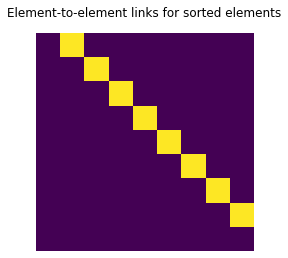

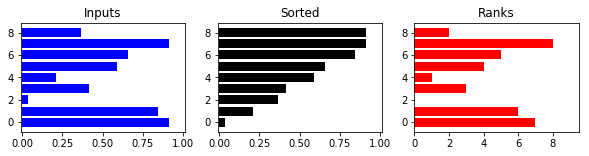

In [0]:
#@title Visualize the sort task  { form-width: "30%" }
tf.reset_default_graph()
num_elements_min_max = (5, 10)

inputs_op, targets_op, sort_indices_op, ranks_op = create_data_ops(
    1, num_elements_min_max)

inputs_op, targets_op, sort_indices_op, ranks_op = make_all_runnable_in_session(
    inputs_op, targets_op, sort_indices_op, ranks_op)

with tf.Session() as sess:
  inputs_nodes, sort_indices_nodes, ranks_nodes, targets = sess.run(
      [inputs_op.nodes, sort_indices_op.nodes, ranks_op.nodes, targets_op])

sort_indices = np.squeeze(sort_indices_nodes).astype(int)

# Plot sort linked lists.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
fig = plt.figure(1, figsize=(4, 4))
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_linked_list(ax,
                 utils_np.graphs_tuple_to_networkxs(targets)[0], sort_indices)
ax.set_title("Element-to-element links for sorted elements")
ax.set_axis_off()

fig = plt.figure(2, figsize=(10, 2))
fig.clf()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

i = 0
num_elements = ranks_nodes.shape[0]
inputs = np.squeeze(inputs_nodes)
ranks = np.squeeze(ranks_nodes * (num_elements - 1.0)).astype(int)
x = np.arange(inputs.shape[0])

ax1.set_title("Inputs")
ax1.barh(x, inputs, color="b")
ax1.set_xlim(-0.01, 1.01)

ax2.set_title("Sorted")
ax2.barh(x, inputs[sort_indices], color="k")
ax2.set_xlim(-0.01, 1.01)

ax3.set_title("Ranks")
ax3.barh(x, ranks, color="r")
_ = ax3.set_xlim(0, len(ranks) + 0.5)

In [0]:
#@title Model training and evaluation setup  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the linked list labeled (using 2-element 1-hot vectors). The target
# labels the node corresponding to the lowest value in the list, and labels each
# which represents the connection between neighboring values in the sorted
# list.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to lists which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on lists with between 8-16 elements.

tf.reset_default_graph()

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 5000
batch_size_tr = 32
batch_size_ge = 100
# Number of elements in each list is sampled uniformly from this range.
num_elements_min_max_tr = (8, 17)
num_elements_min_max_ge = (16, 33)

# Data.
# Training.
inputs_op_tr, targets_op_tr, sort_indices_op_tr, _ = create_data_ops(
    batch_size_tr, num_elements_min_max_tr)
inputs_op_tr = utils_tf.set_zero_edge_features(inputs_op_tr, 1)
inputs_op_tr = utils_tf.set_zero_global_features(inputs_op_tr, 1)
# Test/generalization.
inputs_op_ge, targets_op_ge, sort_indices_op_ge, _ = create_data_ops(
    batch_size_ge, num_elements_min_max_ge)
inputs_op_ge = utils_tf.set_zero_edge_features(inputs_op_ge, 1)
inputs_op_ge = utils_tf.set_zero_global_features(inputs_op_ge, 1)

# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(inputs_op_tr, num_processing_steps_tr)
output_ops_ge = model(inputs_op_ge, num_processing_steps_ge)

# Loss.
loss_ops_tr = create_loss_ops(targets_op_tr, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr  # loss_ops_tr
loss_ops_ge = create_loss_ops(targets_op_ge, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
inputs_op_tr, targets_op_tr, sort_indices_op_tr = make_all_runnable_in_session(
    inputs_op_tr, targets_op_tr, sort_indices_op_tr)
inputs_op_ge, targets_op_ge, sort_indices_op_ge = make_all_runnable_in_session(
    inputs_op_ge, targets_op_ge, sort_indices_op_ge)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [0]:
#@title Run training steps  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  train_values = sess.run({
      "step": step_op,
      "inputs": inputs_op_tr,
      "targets": targets_op_tr,
      "sort_indices": sort_indices_op_tr,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
  })
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    test_values = sess.run({
        "targets": targets_op_ge,
        "loss": loss_op_ge,
        "outputs": output_ops_ge,
    })
    correct_tr, solved_tr = compute_accuracy(train_values["targets"],
                                             train_values["outputs"][-1])
    correct_ge, solved_ge = compute_accuracy(test_values["targets"],
                                             test_values["outputs"][-1])
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)
    losses_ge.append(test_values["loss"])
    corrects_ge.append(correct_ge)
    solveds_ge.append(solved_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, "
          "Str {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"],
              correct_tr, solved_tr, correct_ge, solved_ge))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00011, T 32.1, Ltr 0.6237, Lge 0.4704, Ctr 0.9240, Str 0.0000, Cge 0.9612, Sge 0.0000
# 00034, T 42.2, Ltr 0.5364, Lge 0.3931, Ctr 0.9279, Str 0.0000, Cge 0.9608, Sge 0.0000
# 00084, T 62.6, Ltr 0.4447, Lge 0.3338, Ctr 0.9241, Str 0.0000, Cge 0.9612, Sge 0.0000
# 00136, T 82.9, Ltr 0.3516, Lge 0.2554, Ctr 0.9295, Str 0.0000, Cge 0.9634, Sge 0.0000
# 00188, T 103.0, Ltr 0.3141, Lge 0.2115, Ctr 0.9339, Str 0.0000, Cge 0.9629, Sge 0.0000
# 00240, T 123.1, Ltr 0.2581, Lge 0.1775, Ctr 0.9385, Str 0.0000, Cge 0.9590, Sge 0.0000
# 00292, T 143.2, Ltr 0.1699, Lge 0.1348, Ctr 0.9592, Str 0.0000, Cge 0.9569, Sge 0.0000
# 00344, T 163.3, Ltr 0.1484, Lge 0.1359, Ctr 0.9629

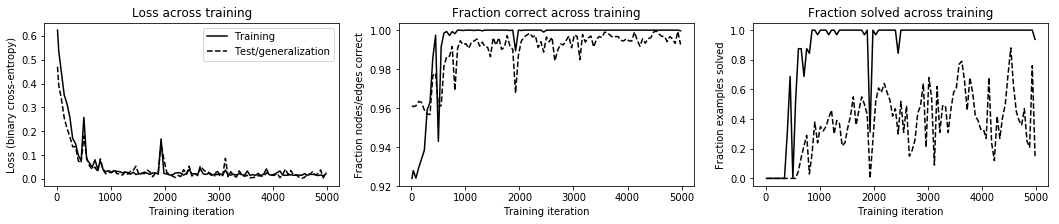

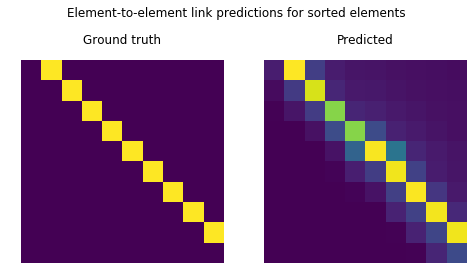

In [0]:
#@title Visualize results  { form-width: "30%" }

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

# Plot results curves.
fig = plt.figure(11, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot sort linked lists for test/generalization.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
outputs = utils_np.graphs_tuple_to_networkxs(train_values["outputs"][-1])
targets = utils_np.graphs_tuple_to_networkxs(train_values["targets"])
inputs = utils_np.graphs_tuple_to_networkxs(train_values["inputs"])
batch_element = 0
fig = plt.figure(12, figsize=(8, 4.5))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sort_indices = np.squeeze(
    utils_np.get_graph(train_values["sort_indices"],
                       batch_element).nodes).astype(int)
fig.suptitle("Element-to-element link predictions for sorted elements")
plot_linked_list(ax1, targets[batch_element], sort_indices)
ax1.set_title("Ground truth")
ax1.set_axis_off()
plot_linked_list(ax2, outputs[batch_element], sort_indices)
ax2.set_title("Predicted")
ax2.set_axis_off()